In [192]:
using LinearAlgebra
using Plots
using LaTeXStrings #Latex Syntax for Plotting
using ITensors
using Plots
using DelimitedFiles

import ITensors: op # Allows overloading of ITensors.op

$$ H = -t\sum_{\sigma = \uparrow, \downarrow} \sum_{j = 1}^{N - 1}( c^{\dagger}_{j, \sigma}c_{j+1, \sigma} + h.c.)+U \sum_{j = 1}^{N} n_{j \uparrow} n_{j \downarrow}$$

In [193]:
using CUDA
gpu = NDTensors.cu

cu (generic function with 1 method)

**Exact Diagonalization Functions:**

In [194]:
C_up = [0 1 0 0; 0 0 0 0; 0 0 0 1; 0 0 0 0] #C_↑
Cdag_up = adjoint(C_up) #C†_↑
C_down = [0 0 1 0; 0 0 0 -1; 0 0 0 0; 0 0 0 0] #C_↓
Cdag_down = adjoint(C_down) #C†_↓
n_up = Cdag_up*C_up #n_↑
n_down = Cdag_down*C_down #n_↓
# P = (-1.0 + 0im)^(n_up + n_down)
P = [1 0 0 0; 0 -1 0 0; 0 0 -1 0; 0 0 0 1] #Parity Operator

4×4 Matrix{Int64}:
 1   0   0  0
 0  -1   0  0
 0   0  -1  0
 0   0   0  1

In [195]:
function Enlarge_Matrix_site_j(j, N, matrix)
    # I⊗...⊗I⊗M⊗I...⊗I

    Identity = zeros(size(matrix))
    for i=1:size(matrix)[1]
        Identity[i,i] = 1
    end
    
    M = Identity
    
    if j == 1
        M = matrix
    end    
    
    for i=2:N 
        if i == j
        M = kron(M, matrix)
        else
        M = kron(M, Identity)        
        end
    end

    return M
end

function Enlarge_Matrix_i_Matrix_j(i,j,N, matrix_i, matrix_j)
    # I⊗...⊗I⊗M_i⊗I...⊗I⊗M_j⊗I⊗I...⊗I

    Identity = zeros(size(matrix_i))
    for i=1:size(matrix_i)[1]
        Identity[i,i] = 1
    end

    M = Identity
    
    if j == 1
        M = matrix_j
    end    

    if i == 1
        M = matrix_i
    end   
    
    for k=2:N 
        if k == j
        M = kron(M, matrix_j)
        elseif k == i
        M = kron(M, matrix_i)
        else
        M = kron(M, Identity)        
        end
    end

    return M
end

Enlarge_Matrix_i_Matrix_j (generic function with 1 method)

In [196]:
# Enlarge_Matrix_i_Matrix_j(2,3,4, Cdag_up*P, C_up) == kron(P*P, Cdag_up*P, C_up, P*P) #Test

In [197]:
function Build_Hamiltonian(t,U, N)

    H = zeros(4^N, 4^N) #Local Hilbert Space Dimension = 4
    
    for k=1:N-1
        H += -t*Enlarge_Matrix_i_Matrix_j(k,k+1,N, Cdag_up*P, C_up) #C†_j,↑*#C_j+1,↑
        H += -t*Enlarge_Matrix_i_Matrix_j(k,k+1,N, Cdag_down*P, C_down) #C†_j,↓*#C_j+1,↓
    end
    H += adjoint(H) #h.c.

    for k=1:N
        H += U*Enlarge_Matrix_site_j(k, N, n_up*n_down) #n_↑*n_↓
    end

    return H
end

function Time_Evolution_Operator(t, H)
    #|Ψ(t)> = exp(-itH)|Ψ(0)>

    return U = exp(-1im*t*H)   
end

function double_occupancy_ED(psi)
    N = log2(length(psi))/2

    d = 0
    for j in 1:N
        Op = Enlarge_Matrix_site_j(j, N, n_up*n_down)
        d += adjoint(psi)*Op*psi
    end
    
   return d/N     
end

function staggered_magnetization_ED(psi)
    N = log2(length(psi))/2
    
    ms = 0
    for j in 1:N
        Nup = Enlarge_Matrix_site_j(j, N, n_up)
        Ndn = Enlarge_Matrix_site_j(j, N, n_down)
        ms += (-1)^(j)*(adjoint(psi)*Nup*psi - adjoint(psi)*Ndn*psi)
    end
    
    return ms/(2*N) 
end

staggered_magnetization_ED (generic function with 1 method)

**ITensor Functions:**

In [198]:
#Definitions JJ:

op(::OpName"PCup",::SiteType"Electron") = [0 1 0 0
                                           0 0 0 0
                                           0 0 0 -1
                                           0 0 0 0]; 

op(::OpName"PCdn",::SiteType"Electron") = [0 0 1 0
                                           0 0 0 1
                                           0 0 0 0
                                           0 0 0 0];

op(::OpName"CdagupP",::SiteType"Electron") = [0 0 0 0
                                              1 0 0 0
                                              0 0 0 0
                                              0 0 -1 0]; 

op(::OpName"CdagdnP",::SiteType"Electron") = [0 0 0 0
                                              0 0 0 0
                                              1 0 0 0
                                              0 1 0 0];

# New version of creation and annihilation operators to use OpSum

op(::OpName"CupNew",::SiteType"Electron") = [0 1 0 0
                                             0 0 0 0
                                             0 0 0 1
                                             0 0 0 0]; 

op(::OpName"CdnNew",::SiteType"Electron") = [0 0 1 0
                                             0 0 0 -1
                                             0 0 0 0
                                             0 0 0 0];

op(::OpName"CdagupNew",::SiteType"Electron") = [0 0 0 0
                                                1 0 0 0
                                                0 0 0 0
                                                0 0 1 0]; 

op(::OpName"CdagdnNew",::SiteType"Electron") = [0 0 0 0
                                                0 0 0 0
                                                1 0 0 0
                                                0 -1 0 0];


In [199]:
function Create_H_MPO(t,U, N, sites = []) 

    if length(sites) == 0
        sites = siteinds("Electron",N)    
    end
    
    os = OpSum() 
    for j=1:N-1 

        #JJ Code: This version is working
        
        # os += -t,"CdagdnP",j,"CdnNew",j+1
        # os += -t,"PCdn",j,"CdagdnNew",j+1
        # os += -t,"CdagupP",j,"CupNew",j+1
        # os += -t,"PCup",j,"CdagupNew",j+1   

        #What if we remove New because they are the same? This version is not working
        # os += -t,"CdagdnP",j,"Cdn",j+1
        # os += -t,"PCdn",j,"Cdagdn",j+1
        # os += -t,"CdagupP",j,"Cup",j+1
        # os += -t,"PCup",j,"Cdagup",j+1               

        #Using default operators Attempt: This version is working

        os += -t,"Cdagup",j,"Cup",j+1 
        os += -t,"Cdagup",j+1,"Cup",j
        os += -t,"Cdagdn",j,"Cdn",j+1 
        os += -t,"Cdagdn",j+1,"Cdn",j

        #Our F is the parity operator, what if we write this? This version is not working
        # os += -t,"Cdagdn * F",j,"Cdn",j+1
        # os += -t,"Cdagdn",j+1,"F * Cdn",j
        # os += -t,"Cdagup * F",j,"Cup",j+1
        # os += -t,"Cdagup",j+1,"F * Cup",j     
    
    end 

    for j=1:N
        os += U,"Nup * Ndn",j
    end
    # Convert these terms to an MPO 
    H = MPO(os,sites)
    return H, sites
end

function double_occupancy_TN(psi)
    N = length(psi)
    sites = siteinds(psi)
    
    d = 0
    for j in 1:N
        Nup = op("Nup", sites[j])
        Ndn = op("Ndn", sites[j])
        d += inner(psi, apply(Nup, apply(Ndn,psi)))
    end
    
    return d/N 
end

function staggered_magnetization_TN(psi)
    N = length(psi)
    sites = siteinds(psi)
    
    ms = 0
    for j in 1:N
        Nup = op("Nup", sites[j])
        Ndn = op("Ndn", sites[j])
        ms += (-1)^(j)*(inner(psi, apply(Nup,psi)) - inner(psi, apply(Ndn,psi)))
    end
    
    return ms/(2*N) 
end

function Von_Neumann_Entropy(psi, site_to_cut) # https://itensor.discourse.group/t/question-about-calculating-entanglement-entropy-of-a-mps/240
  sites = siteinds(psi)  
  orthogonalize!(psi, site_to_cut) #https://itensor.discourse.group/t/the-use-of-orthogonalize/56, orthogonalize creates the mixed MPS centered in side_to_cut.
  U,S,V = svd(psi[site_to_cut], (linkind(psi, site_to_cut-1), sites[site_to_cut]))

  SvN = 0.0
  for n in 1:dim(S, 1)
    p = S[n,n]^2 #Schmidt coefficient
    SvN -= p * log2(p)
  end
  return SvN
end

function TEBD_Values(t, Psi_0, J, U, maxdim = 40, output = false)
    #|Ψ(t)> = exp(-itH)|Ψ(0)> #Main Function

    N = length(Psi_0)
    cutoff = 1E-8
    dt = 0.005
    s = siteinds(Psi_0)
    
    # Make gates (1,2),(2,3),(3,4),...
    Evolution_Gates = ITensor[]    

    for j in 1:(N - 1)
        s1 = s[j]
        s2 = s[j + 1]

        # hj = -J*op("Cdagup", s1)*op("Cup", s2) -J*op("Cdagup", s2)*op("Cup", s1) 
        # hj += -J*op("Cdagdn", s1)*op("Cdn", s2) -J*op("Cdagdn", s2)*op("Cdn", s1) 
        
        hj = -J*op("Cdagup * F", s1)*op("Cup", s2) -J*op("Cdagup", s2)*op("F * Cup", s1) 
        hj += -J*op("Cdagdn * F", s1)*op("Cdn", s2) -J*op("Cdagdn", s2)*op("F * Cdn", s1)  

        hj += U*op("Nup * Ndn", s1)*op("Id", s2)

        if j == N-1
            hj += U*op("Nup * Ndn", s2)*op("Id", s1)
        end

        push!(Evolution_Gates, exp(-im * dt/ 2 * hj))
    end

    append!(Evolution_Gates, reverse(Evolution_Gates))

    d_values = [double_occupancy_TN(Psi_0)] 
    ms_values = [staggered_magnetization_TN(Psi_0)]
    charge_correlations = [correlation_matrix(Psi_0,"Nup  + Ndn","Nup  + Ndn")[Int(N/2),Int(N/2)+1]]
    spin_correlations = [correlation_matrix(Psi_0,"Nup  - Ndn","Nup  - Ndn")[Int(N/2),Int(N/2)+1]/2]
    SVN_values = [Von_Neumann_Entropy(Psi_0, Int(N/2))]

    Times = [0.0]
    
    Psi_t = Psi_0   
        
    for time in dt:dt:t
        Psi_t = apply(Evolution_Gates, Psi_t; cutoff, maxdim)  #Each that apply is executed an SVD is also executed, maxdim is the maximum of the dimension that we will use from the SVD.
        normalize!(Psi_t)

        append!(Times, time)
               
        append!(d_values, double_occupancy_TN(Psi_t).re)
        append!(ms_values, staggered_magnetization_TN(Psi_t).re)
        append!(charge_correlations, (correlation_matrix(Psi_t,"Nup  + Ndn","Nup  + Ndn")[Int(N/2),Int(N/2)+1]).re)
        append!(spin_correlations, (correlation_matrix(Psi_t,"Nup  - Ndn","Nup  - Ndn")[Int(N/2),Int(N/2)+1]/2).re)
        append!(SVN_values, Von_Neumann_Entropy(Psi_t, Int(N/2)))

        if output == true && (time*100/t)%10 == 0.0
            println("Values for t = "*string(time)*" calculated. "*string(round(time*100/t))*"% completed.")
        end
    end
    
    return d_values, ms_values, charge_correlations, spin_correlations, SVN_values, Times
end

TEBD_Values (generic function with 3 methods)

In [200]:
N = 6
t = 1
U = 4
tf = 2

2

In [201]:
#First run values:

N = 4
tf = 0.1

0.1

In [202]:
nsweeps = 10
maxdim = [500] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized
cutoff = [1E-10] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized

1-element Vector{Float64}:
 1.0e-10

In [203]:
H, sites = Create_H_MPO(t,U, N) 
DMRG_observer = DMRGObserver(;energy_tol=10e-8, minsweeps=10, energy_type=Float64)
energy_ground_state, psi_ground_state = dmrg(H,randomMPS(sites); nsweeps, maxdim, cutoff, observer = DMRG_observer) 

After sweep 1 energy=-2.4581296166234394  maxlinkdim=16 maxerr=2.20E-16 time=0.004
After sweep 2 energy=-2.6136706914327976  maxlinkdim=16 maxerr=8.92E-17 time=0.007
After sweep 3 energy=-2.623232900441929  maxlinkdim=16 maxerr=1.03E-18 time=0.019
After sweep 4 energy=-2.6242748673972036  maxlinkdim=16 maxerr=2.37E-16 time=0.009
After sweep 5 energy=-2.624413708220192  maxlinkdim=16 maxerr=1.09E-16 time=0.009
After sweep 6 energy=-2.624435647467654  maxlinkdim=15 maxerr=3.04E-11 time=0.008
After sweep 7 energy=-2.624441547509629  maxlinkdim=14 maxerr=2.90E-11 time=0.009
After sweep 8 energy=-2.6244452507519425  maxlinkdim=13 maxerr=8.70E-11 time=0.010
After sweep 9 energy=-2.6244486581434128  maxlinkdim=13 maxerr=7.56E-11 time=0.009
After sweep 10 energy=-2.62445199866621  maxlinkdim=13 maxerr=2.96E-11 time=0.006


(-2.62445199866621, MPS
[1] ((dim=4|id=904|"Link,l=1"), (dim=4|id=270|"Electron,Site,n=1"))
[2] ((dim=13|id=847|"Link,l=2"), (dim=4|id=389|"Electron,Site,n=2"), (dim=4|id=904|"Link,l=1"))
[3] ((dim=4|id=998|"Electron,Site,n=3"), (dim=4|id=196|"Link,l=3"), (dim=13|id=847|"Link,l=2"))
[4] ((dim=4|id=642|"Electron,Site,n=4"), (dim=4|id=196|"Link,l=3"))
)

In [204]:
# Matrix(op("Cdagup", sites[1]),sites[1]',sites[1]) == Matrix(op("CdagupNew", sites[1]),sites[1]',sites[1]) 
# Matrix(op("Cdagdn", sites[1]),sites[1]',sites[1]) == Matrix(op("CdagdnNew", sites[1]),sites[1]',sites[1]) 
# Matrix(op("Cdn", sites[1]),sites[1]',sites[1]) == Matrix(op("CdnNew", sites[1]),sites[1]',sites[1]) 
# Matrix(op("Cdn", sites[1]),sites[1]',sites[1]) == Matrix(op("CdnNew", sites[1]),sites[1]',sites[1]) 
# Matrix(op("F * Cdn", sites[1]),sites[1]',sites[1]) == Matrix(op("PCdn", sites[1]),sites[1]',sites[1]) 
# Matrix(op("F * Cup", sites[1]),sites[1]',sites[1]) == Matrix(op("PCup", sites[1]),sites[1]',sites[1]) 
# Matrix(op("Cdagup * F", sites[1]),sites[1]',sites[1]) == Matrix(op("CdagupP", sites[1]),sites[1]',sites[1]) 
# Matrix(op("Cdagdn * F", sites[1]),sites[1]',sites[1]) == Matrix(op("CdagdnP", sites[1]),sites[1]',sites[1]) 
# Matrix(op("Cdagup * F", sites[1]),sites[1]',sites[1]) == Cdag_up*P

In [205]:
H_ED = Build_Hamiltonian(t,U, N)
values, vectors = eigen(H_ED)
Psi_0 = vectors[:,1]
values

256-element Vector{Float64}:
 -2.6249422715108643
 -2.6231345819366587
 -2.623134581936658
 -2.236067977499791
 -2.2360679774997907
 -2.2360679774997894
 -1.9979164485755392
 -1.9979164485755376
 -1.95314530868455
 -1.6180339887498978
 -1.618033988749897
 -1.618033988749896
 -1.6180339887498956
  ⋮
 10.623134581936664
 11.381966011250098
 11.381966011250107
 11.999999999999995
 12.275424148388982
 12.618033988749884
 12.618033988749897
 12.859523388615218
 13.412898695919095
 13.618033988749884
 13.618033988749895
 16.0

In [206]:
# adjoint(op("F * Cdn", sites[1]))*delta(sites[1]', sites[1])*delta(sites[1]'', sites[1]')

In [207]:
double_occupancy_ED(Psi_0), double_occupancy_TN(psi_ground_state)

(0.01699397600980088, 0.02359739400596153)

In [208]:
staggered_magnetization_ED(Psi_0), staggered_magnetization_TN(psi_ground_state)

(1.3877787807814457e-17, 1.5882134071255882e-6)

In [209]:
Initial_State = []
for i=1:N

    if i%2==0
        append!(Initial_State, ["Up"])
    else
        append!(Initial_State, ["Dn"])
    end
end

In [210]:
Initial_State

4-element Vector{Any}:
 "Dn"
 "Up"
 "Dn"
 "Up"

In [211]:
H, sites = Create_H_MPO(t,U, N) 
Initial_MPS = MPS(sites, Initial_State)
normalize!(Initial_MPS)

MPS
[1] ((dim=4|id=354|"Electron,Site,n=1"), (dim=1|id=679|"Link,l=1"))
[2] ((dim=1|id=679|"Link,l=1"), (dim=4|id=25|"Electron,Site,n=2"), (dim=1|id=398|"Link,l=2"))
[3] ((dim=1|id=398|"Link,l=2"), (dim=4|id=657|"Electron,Site,n=3"), (dim=1|id=994|"Link,l=3"))
[4] ((dim=1|id=994|"Link,l=3"), (dim=4|id=568|"Electron,Site,n=4"))


In [212]:
d_values_TN, ms_values_TN, charge_correlations_TN, spin_correlations_TN, SVN_values_TN, Times_TN = TEBD_Values(tf, Initial_MPS, t, U)

([0.0, 3.7495807577594755e-5, 0.00014994636532342066, 0.0003372439360869975, 0.0005992109782478955, 0.0009355804217790741, 0.0013459411843749762, 0.001829828747354289, 0.002386695594496798, 0.003015911947503484  …  0.004488467930241238, 0.005330144846725587, 0.006240848072331082, 0.007219551357966374, 0.008265152868138635, 0.009376476654902289, 0.010552274229582352, 0.011791226229883423, 0.013091944179851616, 0.014452972340016914], [0.5, 0.49996250356747696, 0.4998500436373164, 0.49966270546676683, 0.4994006291732914, 0.4990639537395121, 0.4986528764946837, 0.4981676574006634, 0.497608603115652, 0.4969760667083711  …  0.495492189837909, 0.49464178439061857, 0.49371976598276784, 0.49272671395228684, 0.49166325144132583, 0.49053004481788565, 0.4893278030578816, 0.48805727708836255, 0.48671925909259517, 0.4853145817778087], [1.0, 0.9999500064577821, 0.9998000983077157, 0.9995504891123015, 0.9992015319289224, 0.998753745340052, 0.9982078855968719, 0.997564825343938, 0.9968255923433442, 0.9

In [213]:
up = [0.0; 1.0; 0.0; 0.0]
dn = [0.0; 0.0; 1.0; 0.0]

Initial_vector = kron(dn,up,dn,up,dn,up)
Initial_vector = kron(dn,up,dn,up)

256-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [214]:
dt = 0.01

U_Operator = Time_Evolution_Operator(dt, H_ED)

d_values_ED = [double_occupancy_ED(Initial_vector)] 
ms_values_ED = [staggered_magnetization_ED(Initial_vector)]
times_ED = [0.0]

Psi_t = Initial_vector

for k=1:Integer(tf/dt)
    
    Psi_t = U_Operator*Psi_t
    append!(d_values_ED, double_occupancy_ED(Psi_t))
    append!(ms_values_ED, staggered_magnetization_ED(Psi_t))
    append!(times_ED, dt*k)
end

In [215]:
d_values_ED, ms_values_ED, times_ED

([0.0, 0.00014994334342115882, 0.0005990939787500452, 0.0013454173478268626, 0.0023855345878039057, 0.0037147405575282126, 0.005327028925475045, 0.00721512417136595, 0.00937052031297189, 0.011783526130164288, 0.014443316620283628], [0.5, 0.4998500316628005, 0.49940050641927775, 0.49865256218318377, 0.49760809084859964, 0.49626973136794916, 0.4946408601036371, 0.49272557849547555, 0.49052869809773114, 0.4880557230510206, 0.48531283006534287], [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])

In [216]:
scatter(times_ED, d_values_ED, label= L"ED", color = "blue", alpha = 0.2)
plot!(times_TN, d_values_TN, label= L"TEBD", color = "black")
xlabel!(L"t")
ylabel!(L"d(t)")

In [217]:
scatter(times_ED, ms_values_ED, label= L"ED", color = "blue", alpha = 0.2)
plot!(times_TN, ms_values_TN, label= L"TEBD", color = "black")
xlabel!(L"t")
ylabel!(L"m_{s}(t)")

**Figure 1.**

In [218]:
N = 20
t = 1

Initial_State = []
for i=1:N

    if i%2==0
        append!(Initial_State, ["Up"])
    else
        append!(Initial_State, ["Dn"])
    end
end

In [219]:
# sites = siteinds("Electron",N, conserve_qns = true)
sites = siteinds("Electron",N)
Initial_MPS = MPS(sites, Initial_State)
normalize!(Initial_MPS)

MPS
[1] ((dim=4|id=217|"Electron,Site,n=1"), (dim=1|id=375|"Link,l=1"))
[2] ((dim=1|id=375|"Link,l=1"), (dim=4|id=139|"Electron,Site,n=2"), (dim=1|id=113|"Link,l=2"))
[3] ((dim=1|id=113|"Link,l=2"), (dim=4|id=16|"Electron,Site,n=3"), (dim=1|id=560|"Link,l=3"))
[4] ((dim=1|id=560|"Link,l=3"), (dim=4|id=207|"Electron,Site,n=4"), (dim=1|id=925|"Link,l=4"))
[5] ((dim=1|id=925|"Link,l=4"), (dim=4|id=264|"Electron,Site,n=5"), (dim=1|id=697|"Link,l=5"))
[6] ((dim=1|id=697|"Link,l=5"), (dim=4|id=829|"Electron,Site,n=6"), (dim=1|id=263|"Link,l=6"))
[7] ((dim=1|id=263|"Link,l=6"), (dim=4|id=268|"Electron,Site,n=7"), (dim=1|id=594|"Link,l=7"))
[8] ((dim=1|id=594|"Link,l=7"), (dim=4|id=822|"Electron,Site,n=8"), (dim=1|id=260|"Link,l=8"))
[9] ((dim=1|id=260|"Link,l=8"), (dim=4|id=878|"Electron,Site,n=9"), (dim=1|id=683|"Link,l=9"))
[10] ((dim=1|id=683|"Link,l=9"), (dim=4|id=854|"Electron,Site,n=10"), (dim=1|id=687|"Link,l=10"))
[11] ((dim=1|id=687|"Link,l=10"), (dim=4|id=523|"Electron,Site,n=11"), 

In [220]:
d_values_TN_0, ms_values_TN_0, charge_correlations_TN_0, spin_correlations_TN_0, SVN_values_TN_0, times_TN = TEBD_Values(1, Initial_MPS, t, 0, 40, true) #U/t = 0
d_values_TN_4, ms_values_TN_4, charge_correlations_TN_4, spin_correlations_TN_4, SVN_values_TN_4, times_TN = TEBD_Values(1, Initial_MPS, t, 4*t, 40, true) #U/t = 4

#215 segs wo GPU

Values for t = 0.1 calculated. 10.0% completed.
Values for t = 0.2 calculated. 20.0% completed.
Values for t = 0.3 calculated. 30.0% completed.
Values for t = 0.4 calculated. 40.0% completed.
Values for t = 0.5 calculated. 50.0% completed.
Values for t = 0.6 calculated. 60.0% completed.
Values for t = 0.7 calculated. 70.0% completed.
Values for t = 0.8 calculated. 80.0% completed.
Values for t = 0.9 calculated. 90.0% completed.
Values for t = 1.0 calculated. 100.0% completed.
Values for t = 0.1 calculated. 10.0% completed.
Values for t = 0.2 calculated. 20.0% completed.
Values for t = 0.3 calculated. 30.0% completed.
Values for t = 0.4 calculated. 40.0% completed.
Values for t = 0.5 calculated. 50.0% completed.
Values for t = 0.6 calculated. 60.0% completed.
Values for t = 0.7 calculated. 70.0% completed.
Values for t = 0.8 calculated. 80.0% completed.
Values for t = 0.9 calculated. 90.0% completed.
Values for t = 1.0 calculated. 100.0% completed.


([0.0, 4.749366197292381e-5, 0.0001899212901386667, 0.0004271264508096881, 0.0007588510446483375, 0.0011847104115700383, 0.001704124524042298, 0.0023164328652051326, 0.003020857235743534, 0.0038165029651784665  …  0.11088366840388897, 0.11127484594475427, 0.11168072102583512, 0.1121000729803145, 0.11253166951141325, 0.11297427602666668, 0.11342664838143142, 0.11388753987645608, 0.11435569563679111, 0.1148298700295967], [0.5, 0.499952505213147, 0.4998100607153634, 0.4995727824814925, 0.49924086126566325, 0.49881449167289027, 0.4982939474170155, 0.4976795866954384, 0.49697183192475763, 0.49617116928546245  …  0.0928250882752775, 0.09176818789773675, 0.09069836126289757, 0.0896153959839069, 0.08851910400076116, 0.08740932795355662, 0.08628593443850892, 0.0851488148418957, 0.08399789105995462, 0.08283310803486224], [1.0, 0.99995000812426, 0.9998001049704404, 0.9995505040830789, 0.9992015584608804, 0.9987537865422693, 0.9982079442863155, 0.9975649038221673, 0.996825692077525, 0.995991488889

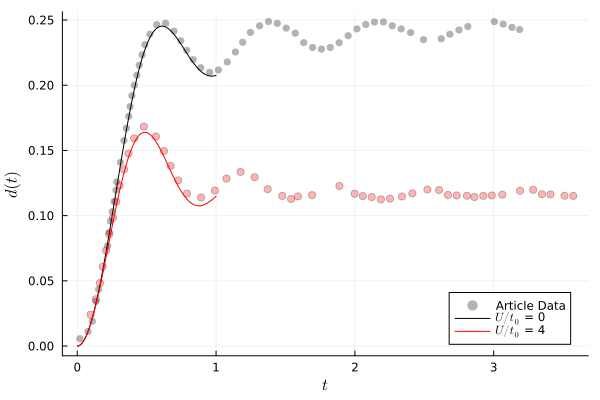

In [221]:
Figure_Data = readdlm("txt_files/Fermi_Hubbard_Figure1a_Gray.txt", ',', Float64)
scatter(Figure_Data[:,1], Figure_Data[:,2], label = "Article Data", color = "black", alpha = 0.3 )
plot!(times_TN, d_values_TN_0, label= L"$U/t_{0}$ = 0", color = "black")


Figure_Data = readdlm("txt_files/Fermi_Hubbard_Figure1a_Red.txt", ',', Float64)
scatter!(Figure_Data[:,1], Figure_Data[:,2], label = false, color = "red", alpha = 0.3 )
plot!(times_TN, d_values_TN_4, label= L"$U/t_{0}$ = 4", color = "red")

xlabel!(L"t")
ylabel!(L"d(t)")

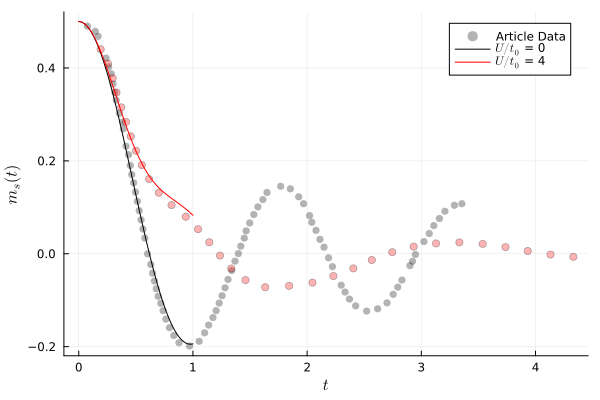

In [222]:
Figure_Data = readdlm("txt_files/Fermi_Hubbard_Figure1b_Gray.txt", ',', Float64)
scatter(Figure_Data[:,1], Figure_Data[:,2], label = "Article Data", color = "black", alpha = 0.3 )
plot!(times_TN, ms_values_TN_0, label= L"$U/t_{0}$ = 0", color = "black")


Figure_Data = readdlm("txt_files/Fermi_Hubbard_Figure1b_Red.txt", ',', Float64)
scatter!(Figure_Data[:,1], Figure_Data[:,2], label = false, color = "red", alpha = 0.3 )
plot!(times_TN, ms_values_TN_4, label= L"$U/t_{0}$ = 4", color = "red")

xlabel!(L"t")
ylabel!(L"m_{s}(t)")

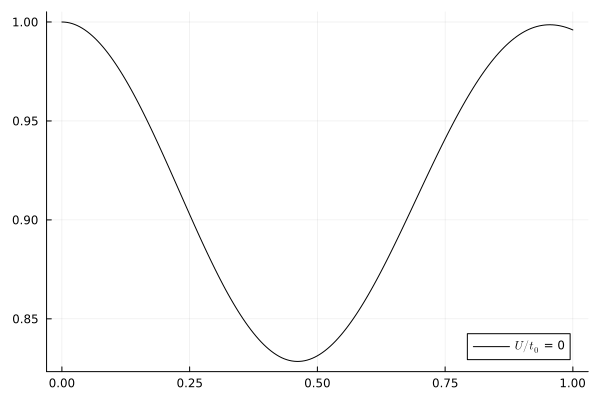

In [223]:
plot(times_TN, charge_correlations_TN_0, label= L"$U/t_{0}$ = 0", color = "black")


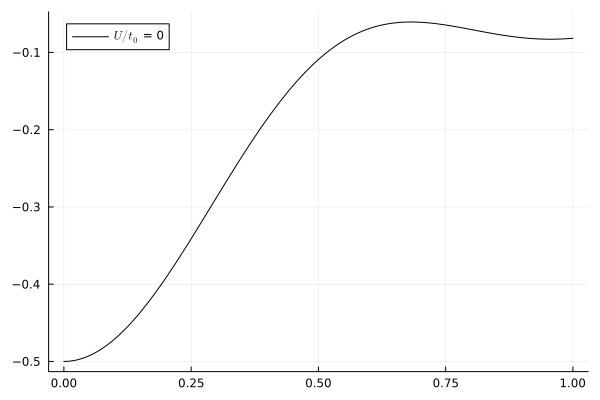

In [224]:
plot(times_TN, spin_correlations_TN_0, label= L"$U/t_{0}$ = 0", color = "black")


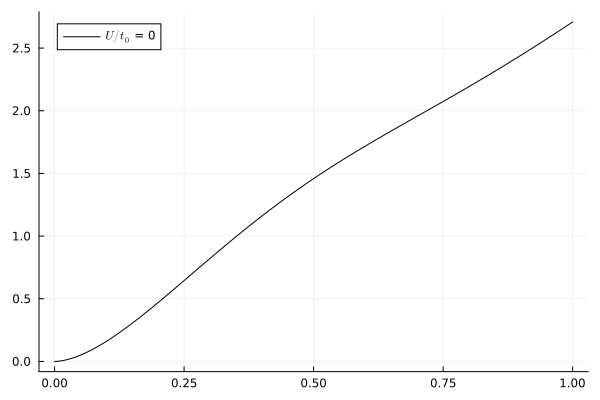

In [228]:
plot(times_TN, SVN_values_TN_0, label= L"$U/t_{0}$ = 0", color = "black")
